# Udaplay Project

## Part 02 - Agent

In this part of the project, you'll use your VectorDB to be part of your Agent as a tool.

You're building UdaPlay, an AI Research Agent for the video game industry. The agent will:
1. Answer questions using internal knowledge (RAG)
2. Search the web when needed
3. Maintain conversation state
4. Return structured outputs
5. Store useful information for future use

### Setup

In [1]:
# Only needed for Udacity workspace

import importlib.util
import sys

# Check if 'pysqlite3' is available before importing
if importlib.util.find_spec("pysqlite3") is not None:
    import pysqlite3
    sys.modules['sqlite3'] = sys.modules.pop('pysqlite3')

In [2]:
import os
import json
from typing import List, Dict, Any, Optional, Literal, TypedDict

from dotenv import load_dotenv

from lib.agents import Agent
from lib.llm import LLM
from lib.messages import UserMessage, SystemMessage, ToolMessage, AIMessage
from lib.tooling import tool, Tool
from lib.vector_db import VectorStoreManager, CorpusLoaderService

#### Environment Setup
Loads API keys (`OPENAI_API_KEY`, `TAVILY_API_KEY`) and validates prerequisites. These keys power embeddings, chat completions, and web search. Keep them in your environment or a `.env` file.


In [3]:
# Load environment variables
load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")

if not OPENAI_API_KEY:
    raise RuntimeError("OPENAI_API_KEY is required")

#### Vector DB Initialization
Initializes a `VectorStoreManager` and uses `CorpusLoaderService.load_json_dir` to ingest the games JSON corpus into a Chroma collection (`games_market`). This enables semantic search with OpenAI embeddings and metadata filtering.


In [4]:
from pathlib import Path

manager = VectorStoreManager(openai_api_key=OPENAI_API_KEY)
loader = CorpusLoaderService(manager)
games_store = loader.load_json_dir("games_market", './games')


VectorStore `games_market` ready!
JSON loaded from `./games`!


### Tools

Build at least 3 tools:
- retrieve_game: To search the vector DB
- evaluate_retrieval: To assess the retrieval performance
- game_web_search: If no good, search the web


#### Retrieve Game Tool
Vector search over the `games_market` collection. Supports metadata filters (e.g., `Platform`, `YearOfRelease`). Returns a ranked list with similarity scores and essential fields for answer synthesis.


In [5]:
class ToolStatus(TypedDict, total=False):
    status: Literal["ok", "no_context", "error"]
    error: Optional[str]

class RetrievedDoc(TypedDict, total=False):
    Name: str
    Platform: str
    YearOfRelease: int
    Description: str
    similarity: float

class RetrieveGameResult(ToolStatus, total=False):
    results: List[RetrievedDoc]

@tool
def retrieve_game(query: str, n_results: int = 5, platform: Optional[str] = None, year: Optional[int] = None) -> RetrieveGameResult:
    """
    Semantic search: Finds the most similar game documents in the vector DB.
    args:
    - query: question about games or a fuzzy description
    - n_results: number of matches to return (default 5)
    - platform: optional metadata filter (exact match)
    - year: optional metadata filter (exact match)
    """
    where: Dict[str, Any] = {}
    if platform:
        where["Platform"] = platform
    if year is not None:
        where["YearOfRelease"] = year

    res = games_store.query(
        query_texts=[query],
        n_results=max(1, int(n_results)),
        where=where or None
    )
    metas = res["metadatas"][0]
    dists = res["distances"][0]

    if not metas:
        return {"status": "no_context", "results": []}

    results: List[RetrievedDoc] = []
    for meta, dist in zip(metas, dists):
        results.append({
            "Name": meta.get("Name", ""),
            "Platform": meta.get("Platform", ""),
            "YearOfRelease": meta.get("YearOfRelease", 0),
            "Description": meta.get("Description", ""),
            "similarity": max(0.0, 1.0 - float(dist)),
        })
    return {"status": "ok", "results": results}

#### Evaluate Retrieval Tool
Uses the model as a judge to decide whether retrieved documents are sufficient to answer the user’s question. Returns `useful`, `description`, and a `score` in [0,1]. This lets the workflow branch to web search when local context is inadequate.


In [6]:
class EvaluationReport(TypedDict, total=False):
    useful: bool
    description: str
    score: float  # 0..1

class EvaluateRetrievalResult(TypedDict, total=False):
    status: Literal["ok", "no_context", "error"]
    error: Optional[str]
    evaluation: EvaluationReport

@tool
def evaluate_retrieval(question: str, retrieved_docs: List[RetrievedDoc]) -> EvaluateRetrievalResult:
    """
    Based on the user's question and the retrieved documents, analyze if they are
    sufficient to answer the question. Returns an evaluation with usefulness,
    explanation, and a score in [0,1].
    args:
    - question: original question from user
    - retrieved_docs: retrieved documents most similar to the user query in the Vector Database
    """
    if not retrieved_docs:
        return {"status": "no_context", "evaluation": {"useful": False, "description": "No documents.", "score": 0.0}}

    llm = LLM(model="gpt-4o-mini", temperature=0.0)
    docs_str = "\n".join(
        f"- {d['Name']} ({d['YearOfRelease']}) [{d['Platform']}] sim={d.get('similarity',0):.2f}\n  {d['Description']}"
        for d in retrieved_docs[:5]
    )
    prompt = (
        "You are an evaluator. Decide if the retrieved documents are enough to answer the question.\n"
        "Return STRICT JSON with keys: useful (bool), description (string), score (float in [0,1]).\n\n"
        f"Question: {question}\n"
        f"Documents:\n{docs_str}\n\n"
        "JSON:"
    )
    msg = llm.invoke(prompt)
    try:
        data = json.loads(msg.content or "{}")
        useful = bool(data.get("useful", False))
        desc = str(data.get("description", ""))
        score = float(data.get("score", 0.0))
    except Exception:
        useful = True if "yes" in (msg.content or "").lower() else False
        desc = (msg.content or "").strip()[:300]
        score = 0.7 if useful else 0.3

    return {"status": "ok", "evaluation": {"useful": useful, "description": desc, "score": score}}

#### Game Web Search Tool
Wraps our Tavily‑powered `web_search` into a domain‑specific tool. It’s used when local retrieval is weak or absent. The tool returns a structured envelope with an `answer`, raw `results`, and search metadata, enabling downstream comparison or synthesis.


In [7]:
from lib.tools import web_search as _web_search

class GameWebSearchResult(TypedDict, total=False):
    status: Literal["ok", "no_context", "error"]
    data: Dict[str, Any]

@tool
def game_web_search(question: str, max_results: int = 5) -> GameWebSearchResult:
    """
    Web search via Tavily for game industry queries.
    args:
    - question: a question about the game industry.
    - max_results: number of results to return.
    """
    result = _web_search(query=question, max_results=max_results)
    return result

### Agent

We construct the `Agent` with three tools and clear instructions for routing: use `retrieve_game` first, assess with `evaluate_retrieval`, then fall back to `game_web_search` if needed. Tool docstrings and return schemas are auto‑injected into the system prompt, and strict validation ensures typed returns.


In [8]:
tools = [retrieve_game, evaluate_retrieval, game_web_search]

agent = Agent(
    model_name="gpt-4o-mini",
    tools=tools,
    instructions=(
        "You are UdaPlay, an AI research agent for the video game industry.\n"
        "- Prefer retrieve_game to answer via internal knowledge.\n"
        "- If retrieval seems weak, call evaluate_retrieval; if not useful, try game_web_search.\n"
        "- Keep answers concise and cite key facts. Ask clarifying questions if ambiguous."
    ),
    include_tool_docs=True,
    strict_tool_validation=True,
)

print("Agent ready with tools:", [t.name for t in tools])

Agent ready with tools: ['retrieve_game', 'evaluate_retrieval', 'game_web_search']


In [9]:
queries = [
    "When were Pokémon Gold and Silver released?",
    "Which was the first 3D platformer Mario game?",
    "Was Mortal Kombat X released for PlayStation 5?",
]

for q in queries:
    run = agent.invoke(q)
    final = run.get_final_state()
   
     # Inspect tool calls across the run
    for msg in final.get("messages", []):
        if isinstance(msg, AIMessage) and msg.tool_calls:
            for tc in msg.tool_calls:
                print("tool:", tc.function.name, "args:", tc.function.arguments)

    # And all tool results in order
    for msg in final.get("messages", []):
        if isinstance(msg, ToolMessage):
            print("tool_result:", msg.name, msg.content[:200], "...")

    # Existing answer print
    print(f"\nQ: {q}\nA:")
    if final.get("messages"):
        for m in reversed(final["messages"]):
            if isinstance(m, AIMessage) and m.content:
                print(m.content)
                break


[StateMachine] Starting: __entry__
[StateMachine] Executing step: message_prep
[StateMachine] Executing step: llm_processor
[StateMachine] Executing step: tool_executor
[StateMachine] Executing step: llm_processor
[StateMachine] Terminating: __termination__
tool: retrieve_game args: {"query":"Pokémon Gold and Silver release date"}
tool_result: retrieve_game {"status": "ok", "results": [{"Name": "Pok\u00e9mon Gold and Silver", "Platform": "Game Boy Color", "YearOfRelease": 1999, "Description": "Second-generation Pok\u00e9mon games introducing new regions, ...

Q: When were Pokémon Gold and Silver released?
A:
Pokémon Gold and Silver were released for the Game Boy Color in 1999.
[StateMachine] Starting: __entry__
[StateMachine] Executing step: message_prep
[StateMachine] Executing step: llm_processor
[StateMachine] Executing step: tool_executor
[StateMachine] Executing step: llm_processor
[StateMachine] Terminating: __termination__
tool: retrieve_game args: {"query":"Pokémon Gold and Sil

#### Agent Trace
This diagnostic cell runs the Agent and prints a per-run trace: workflow steps, tools invoked, arguments, and tokens. Use it to debug routing and verify token usage is captured via `total_tokens` and `cumulative_tokens`.


In [10]:
from pprint import pprint

queries = [
    "When were Pokémon Gold and Silver released?",
    "Which was the first 3D platformer Mario game?",
    "Was Mortal Kombat X released for PlayStation 5?",
]

for q in queries:
    run = agent.invoke(q, session_id="trace_demo")
    final = run.get_final_state() or {}

    # Collect tools used from messages
    tools_used = []
    for msg in final.get("messages", []) or []:
        if isinstance(msg, AIMessage) and msg.tool_calls:
            tools_used.extend([tc.function.name for tc in msg.tool_calls])

    print(f"\nQ: {q}")
    # Final answer (last AI message content)
    answer = ""
    for m in reversed(final.get("messages", [])):
        if isinstance(m, AIMessage) and m.content:
            answer = m.content
            break
    print("A:", answer)

    # Tokens
    print("tokens: last=", final.get("total_tokens"), " cumulative=", final.get("cumulative_tokens"))
    print("tools used:", tools_used)

    # Optional: print the last tool result envelope (if any)
    last_tool_json = None
    for m in reversed(final.get("messages", [])):
        if isinstance(m, ToolMessage) and m.content:
            last_tool_json = m.content
            break
    if last_tool_json:
        print("last tool result (truncated):")
        print((last_tool_json[:300] + "...") if len(last_tool_json) > 300 else last_tool_json)



[StateMachine] Starting: __entry__
[StateMachine] Executing step: message_prep
[StateMachine] Executing step: llm_processor
[StateMachine] Executing step: tool_executor
[StateMachine] Executing step: llm_processor
[StateMachine] Terminating: __termination__

Q: When were Pokémon Gold and Silver released?
A: Pokémon Gold and Silver were released in 1999 for the Game Boy Color. These games introduced new regions, Pokémon, and gameplay mechanics.
tokens: last= 1768  cumulative= 3134
tools used: ['retrieve_game']
last tool result (truncated):
{"status": "ok", "results": [{"Name": "Pok\u00e9mon Gold and Silver", "Platform": "Game Boy Color", "YearOfRelease": 1999, "Description": "Second-generation Pok\u00e9mon games introducing new regions, Pok\u00e9mon, and gameplay mechanics.", "similarity": 0.7487452924251556}, {"Name": "Pok\u00e9mon R...
[StateMachine] Starting: __entry__
[StateMachine] Executing step: message_prep
[StateMachine] Executing step: llm_processor
[StateMachine] Executing st

#### Advanced: Long‑term Memory
We add `store_memory` and `search_memory` tools on top of a Chroma‑backed `LongTermMemory`. Memories are stored as vectorized `Document`s with metadata (`owner`, `namespace`, `timestamp`). Use memory to persist useful facts/preferences across sessions and restarts, and to prime answers before hitting the web.


In [11]:
# Long-term memory tools and agent update
from lib.memory import LongTermMemory, MemoryFragment, TimestampFilter

ltm = LongTermMemory(manager)

class StoreMemoryResult(TypedDict, total=False):
    status: Literal["ok", "error"]
    error: Optional[str]

class SearchMemoryHit(TypedDict, total=False):
    content: str
    owner: str
    namespace: str
    timestamp: int

class SearchMemoryResult(TypedDict, total=False):
    status: Literal["ok", "no_context", "error"]
    error: Optional[str]
    results: List[SearchMemoryHit]

@tool
def store_memory(content: str, owner: str = "user", namespace: str = "notes") -> StoreMemoryResult:
    """
    Persist a memory fragment for later retrieval.
    args:
    - content: text to store
    - owner: owner identifier (default: "user")
    - namespace: logical bucket (default: "notes")
    """
    try:
        ltm.register(MemoryFragment(content=content, owner=owner, namespace=namespace))
        return {"status": "ok"}
    except Exception as e:
        return {"status": "error", "error": str(e)}

@tool
def search_memory(query: str, owner: str = "user", namespace: str = "notes", limit: int = 3,
                  since: Optional[int] = None, until: Optional[int] = None) -> SearchMemoryResult:
    """
    Semantic search over long-term memory.
    args:
    - query: search text
    - owner: owner identifier
    - namespace: namespace bucket
    - limit: number of results
    - since: optional lower timestamp bound (unix seconds)
    - until: optional upper timestamp bound (unix seconds)
    """
    ts_filter = None
    if since or until:
        ts_filter = TimestampFilter(greater_than_value=since, lower_than_value=until)
    result = ltm.search(query_text=query, owner=owner, limit=limit, timestamp_filter=ts_filter, namespace=namespace)
    if not result.fragments:
        return {"status": "no_context", "results": []}
    out: List[SearchMemoryHit] = []
    for frag in result.fragments:
        out.append({
            "content": frag.content,
            "owner": frag.owner,
            "namespace": frag.namespace,
            "timestamp": frag.timestamp,
        })
    return {"status": "ok", "results": out}

# Update agent to include memory tools
tools = [retrieve_game, evaluate_retrieval, game_web_search, store_memory, search_memory]
agent = Agent(
    model_name="gpt-4o-mini",
    tools=tools,
    instructions=(
        "You are UdaPlay, an AI research agent for the video game industry.\n"
        "- Prefer retrieve_game to answer via internal knowledge.\n"
        "- If retrieval seems weak, call evaluate_retrieval; if not useful, try game_web_search.\n"
        "- Use search_memory/store_memory to recall and persist useful facts.\n"
        "- Keep answers concise; ask clarifying questions if ambiguous."
    ),
    include_tool_docs=True,
    strict_tool_validation=True,
)
print("Agent updated with memory tools:", [t.name for t in tools])


Agent updated with memory tools: ['retrieve_game', 'evaluate_retrieval', 'game_web_search', 'store_memory', 'search_memory']


#### Orchestrator Workflow
This section builds a minimal StateMachine with three steps: `retrieve` (query vector DB), `evaluate` (judge usefulness), and `answer` (compose a concise reply). If evaluation deems retrieval insufficient, we fall back to the Agent (which can use web search). This demonstrates explicit orchestration alongside the Agent abstraction.


In [12]:
# Orchestrator StateMachine wiring tools as nodes (with trace)
from lib.state_machine import StateMachine, Step, EntryPoint, Termination

# Define a minimal state for this workflow with trace
class OrchestratorState(TypedDict):
    question: str
    retrieved: List[RetrievedDoc]
    eval: EvaluationReport
    answer: str
    trace: List[Dict[str, Any]]

# Steps with trace logging

def step_retrieve(state: OrchestratorState) -> OrchestratorState:
    r = retrieve_game(query=state.get("question", ""), n_results=5)
    retrieved = r.get("results", []) if r.get("status") == "ok" else []
    evt = {
        "step": "retrieve",
        "tool": "retrieve_game",
        "args": {"n_results": 5},
        "results_count": len(retrieved),
        "top_names": [d.get("Name") for d in retrieved[:3]],
    }
    trace = (state.get("trace") or []) + [evt]
    return {"retrieved": retrieved, "trace": trace}

def step_evaluate(state: OrchestratorState) -> OrchestratorState:
    r = evaluate_retrieval(question=state.get("question", ""), retrieved_docs=state.get("retrieved", []))
    ev = r.get("evaluation", {"useful": False, "description": "", "score": 0.0})
    evt = {
        "step": "evaluate",
        "tool": "evaluate_retrieval",
        "evaluation": ev,
    }
    trace = (state.get("trace") or []) + [evt]
    return {"eval": ev, "trace": trace}

def step_answer(state: OrchestratorState) -> OrchestratorState:
    trace = state.get("trace") or []
    # If retrieval judged useful, compose; else fall back to Agent (web search capable)
    if state.get("eval", {}).get("useful"):
        llm = LLM(model="gpt-4o-mini", temperature=0.0)
        facts = "\n".join(
            f"- {d['Name']} ({d['YearOfRelease']}) [{d['Platform']}]" for d in state.get("retrieved", [])[:5]
        )
        prompt = (
            f"Question: {state.get('question','')}\n"
            f"Facts:\n{facts}\n\n"
            "Compose a concise answer citing key facts."
        )
        msg = llm.invoke(prompt)
        evt = {
            "step": "answer",
            "mode": "compose",
            "tokens": (llm.last_usage or {}).get("total_tokens"),
        }
        trace.append(evt)
        return {"answer": (msg.content or "").strip(), "trace": trace}
    else:
        run = agent.invoke(f"Web search and answer: {state.get('question','')}")
        final = run.get_final_state()
        text = ""
        tools_used: List[str] = []
        if final and final.get("messages"):
            for m in final["messages"]:
                if isinstance(m, AIMessage) and m.tool_calls:
                    tools_used.extend([tc.function.name for tc in m.tool_calls])
            for m in reversed(final["messages"]):
                if isinstance(m, AIMessage) and m.content:
                    text = m.content
                    break
        evt = {
            "step": "answer",
            "mode": "agent_fallback",
            "tools_used": tools_used,
        }
        trace.append(evt)
        return {"answer": text, "trace": trace}

# Build machine
orch = StateMachine[OrchestratorState](OrchestratorState)
entry = EntryPoint[OrchestratorState]()
retrieve_step = Step[OrchestratorState]("retrieve", step_retrieve)
evaluate_step = Step[OrchestratorState]("evaluate", step_evaluate)
answer_step = Step[OrchestratorState]("answer", step_answer)
term = Termination[OrchestratorState]()

orch.add_steps([entry, retrieve_step, evaluate_step, answer_step, term])
orch.connect(entry, retrieve_step)
orch.connect(retrieve_step, evaluate_step)
# Always proceed to 'answer'; the step decides to compose or fall back
orch.connect(evaluate_step, answer_step)
orch.connect(answer_step, term)

print("Orchestrator ready (with trace).")

Orchestrator ready (with trace).


#### Orchestrator Test
We execute the explicit StateMachine (`orch`) on a few sample questions. The logs show each step execution and any fallback to the Agent. The final state’s `answer` is printed to validate end‑to‑end behavior without relying on the Agent’s internal workflow.


In [13]:
# Test the orchestrator with a few questions
tests = [
    "What is the best racing game on PlayStation from the late 90s?",
    "When were Pokémon Gold and Silver released?",
    "Was Mortal Kombat X released for PlayStation 5?"
]

for q in tests:
    initial = {"question": q}
    run = orch.run(initial)
    final = run.get_final_state() or {}
    print(f"\nQ: {q}\nA: {final.get('answer','<no answer>')}")

[StateMachine] Starting: __entry__
[StateMachine] Executing step: retrieve
[StateMachine] Executing step: evaluate
[StateMachine] Starting: __entry__
[StateMachine] Executing step: message_prep
[StateMachine] Executing step: llm_processor
[StateMachine] Executing step: tool_executor
[StateMachine] Executing step: llm_processor
[StateMachine] Terminating: __termination__
[StateMachine] Executing step: answer
[StateMachine] Terminating: __termination__

Q: What is the best racing game on PlayStation from the late 90s?
A: The best racing game on PlayStation from the late 90s is widely regarded to be **Ridge Racer Type 4**. It is praised for its smooth controls, fantastic graphics, and iconic tracks. 

For more details, you can check out this [list of top racing games](https://traxion.gg/ranked-top-10-best-original-playstation-psx-racing-games/) or see discussions about it on Reddit [here](https://www.reddit.com/r/psx/comments/w5cdk0/best_psx_racing_game/).
[StateMachine] Starting: __entry

#### Seeding Curated Facts
This section augments the RAG knowledge with authoritative facts that aren’t present in the JSON corpus. We store them in long‑term memory under a `facts` namespace using `store_memory`, then run a quick `search_memory` to verify. These entries persist across runs and improve recall for specific queries.


#### Agent Trace (with args)
This cell extends the Agent trace by printing each tool call with its arguments, followed by tokens, tools used, and the last tool result envelope. Use this to diagnose repeated or redundant calls.


In [14]:
queries = [
    "When were Pokémon Gold and Silver released?",
    "Which was the first 3D platformer Mario game?",
    "Was Mortal Kombat X released for PlayStation 5?",
]

for q in queries:
    run = agent.invoke(q, session_id="trace_with_args")
    final = run.get_final_state() or {}

    print(f"\nQ: {q}")

    # Print tool calls with arguments (chronological)
    for msg in final.get("messages", []) or []:
        if isinstance(msg, AIMessage) and msg.tool_calls:
            for tc in msg.tool_calls:
                print("tool:", tc.function.name, "args:", tc.function.arguments)

    # Print tool results (chronological, truncated)
    for msg in final.get("messages", []) or []:
        if isinstance(msg, ToolMessage) and msg.content:
            preview = msg.content[:240] + ("..." if len(msg.content) > 240 else "")
            print("tool_result:", msg.name, preview)

    # Final answer (last AI content)
    answer = ""
    for m in reversed(final.get("messages", [])):
        if isinstance(m, AIMessage) and m.content:
            answer = m.content
            break
    print("A:", answer)

    # Tokens summary
    print("tokens: last=", final.get("total_tokens"), " cumulative=", final.get("cumulative_tokens"))


[StateMachine] Starting: __entry__
[StateMachine] Executing step: message_prep
[StateMachine] Executing step: llm_processor
[StateMachine] Executing step: tool_executor
[StateMachine] Executing step: llm_processor
[StateMachine] Terminating: __termination__

Q: When were Pokémon Gold and Silver released?
tool: retrieve_game args: {"query":"Pokémon Gold and Silver"}
tool_result: retrieve_game {"status": "ok", "results": [{"Name": "Pok\u00e9mon Gold and Silver", "Platform": "Game Boy Color", "YearOfRelease": 1999, "Description": "Second-generation Pok\u00e9mon games introducing new regions, Pok\u00e9mon, and gameplay mechanics.",...
A: Pokémon Gold and Silver were released in 1999 for the Game Boy Color.
tokens: last= 2489  cumulative= 4590
[StateMachine] Starting: __entry__
[StateMachine] Executing step: message_prep
[StateMachine] Executing step: llm_processor
[StateMachine] Executing step: tool_executor
[StateMachine] Executing step: llm_processor
[StateMachine] Terminating: __termina

#### Session Demo (Short‑term Memory)
The agent can handle multiple queries in the same `session_id`, automatically carrying forward prior context. This example shows a follow‑up flow where later questions omit repeated context but the agent still answers correctly.


In [17]:
session_id = "exec_demo"

turns = [
    "Summarize Gran Turismo and why it mattered.",
    "And what platform did it debut on?",
    "Give me another seminal racing title from that era and its year.",
]

for i, q in enumerate(turns, 1):
    run = agent.invoke(q, session_id=session_id)
    final = run.get_final_state() or {}
    answer = ""
    if final.get("messages"):
        for m in reversed(final["messages"]):
            if isinstance(m, AIMessage) and m.content:
                answer = m.content
                break
    print(f"Turn {i}: {q}\n{answer}\n")


[StateMachine] Starting: __entry__
[StateMachine] Executing step: message_prep
[StateMachine] Executing step: llm_processor
[StateMachine] Executing step: tool_executor
[StateMachine] Executing step: llm_processor
[StateMachine] Terminating: __termination__
Turn 1: Summarize Gran Turismo and why it mattered.
**Gran Turismo** is a racing simulator developed by Polyphony Digital, first released for the PlayStation 1 in 1997. It featured a realistic approach to racing, offering a wide array of cars and tracks, which set a new standard for the racing genre. 

### Why It Mattered:
1. **Realism**: Gran Turismo was notable for its attention to detail in car physics and handling, making it a pioneer in realistic racing simulations.
2. **Diverse Vehicle Selection**: It introduced players to a vast selection of licensed vehicles, allowing for extensive customization and tuning.
3. **Cultural Impact**: The game influenced the racing genre significantly and helped popularize sim racing, paving the

In [15]:
# Seed curated facts into long-term memory (outside the JSON corpus)
canonical_facts = [
    "Super Mario 64 is the first 3D Mario platformer (Nintendo 64, 1996).",
    "Pokémon Gold and Silver released in 1999 for Game Boy Color.",
    "Mortal Kombat X released for PlayStation 4 and Xbox One; PS5 via backward compatibility, not native.",
    "Gran Turismo pioneered realistic console sim racing on PlayStation (late 1990s).",
    "The Legend of Zelda: Ocarina of Time (N64, 1998) is widely cited as a benchmark for 3D action-adventure design.",
    "The first video game was 'Tennis for Two,' created in 1958 by physicist William Higinbotham at the Brookhaven National Laboratory, displayed on an oscilloscope screen.",
    "Mario was originally a carpenter, not a plumber, appearing in the 1981 arcade game 'Donkey Kong' before later becoming the iconic plumber we know today.",
    "Pac-Man's distinctive circular shape was directly inspired by a pizza with a slice missing, conceived by creator Toru Iwatani during dinner.",
    "The notorious E.T. video game for the Atari 2600 was such a commercial failure that thousands of unsold cartridges were buried in a New Mexico landfill after its rushed five-week development.",
    "The famous Konami Code (Up, Up, Down, Down, Left, Right, Left, Right, B, A, Start) has appeared in over 100 different games across various platforms.",
    "The controversial content in Mortal Kombat led directly to the creation of the Entertainment Software Rating Board (ESRB) rating system.",
    "Nintendo began its business in 1889 manufacturing handmade playing cards for a Japanese card game called Hanafuda, long before entering the gaming industry.",
    "The Game Boy proved remarkably durable when one unit survived a bombing during the Gulf War and remains functional today.",
    "Minecraft holds the record as the best-selling video game of all time, with over 300 million copies sold as of 2024.",
    "The World Health Organization officially recognizes gaming addiction as a disorder, characterized by impaired control over gaming behavior and prioritizing gaming over other life interests.",
    "Action video games have been scientifically proven to improve players' vision by enhancing spatial resolution and color shade distinction abilities.",
    "Grand Theft Auto V was the most expensive game ever produced at its release, with a development budget of $265 million, though this record has since been broken by Star Citizen ($590 million)."
]

for fact in canonical_facts:
    out = store_memory(content=fact, owner="u1", namespace="facts")
    print(out)

{'status': 'ok'}
{'status': 'ok'}
{'status': 'ok'}
{'status': 'ok'}
{'status': 'ok'}
{'status': 'ok'}
{'status': 'ok'}
{'status': 'ok'}
{'status': 'ok'}
{'status': 'ok'}
{'status': 'ok'}
{'status': 'ok'}
{'status': 'ok'}
{'status': 'ok'}
{'status': 'ok'}
{'status': 'ok'}
{'status': 'ok'}


In [16]:

# Test 1: Search for Nintendo-related facts
print(search_memory(query="Nintendo", owner="u1", namespace="facts"))

# Test 2: Search for specific game titles
print(search_memory(query="Super Mario 64", owner="u1", namespace="facts"))

# Test 3: Search for specific years
print(search_memory(query="1999", owner="u1", namespace="facts"))

# Test 4: Search for specific platforms
print(search_memory(query="PlayStation", owner="u1", namespace="facts"))

# Test 5: Search for specific developers
print(search_memory(query="Konami", owner="u1", namespace="facts"))

# Test 6: Search for specific events
print(search_memory(query="landfill", owner="u1", namespace="facts"))

# Test 7: Search for specific game genres
print(search_memory(query="racing", owner="u1", namespace="facts"))

# Test 8: Search for specific business aspects
print(search_memory(query="budget", owner="u1", namespace="facts"))

# Test 9: Search for specific gaming concepts
print(search_memory(query="addiction", owner="u1", namespace="facts"))

# Test 10: Search for specific technical aspects
print(search_memory(query="vision", owner="u1", namespace="facts"))

{'status': 'ok', 'results': [{'content': 'Nintendo began its business in 1889 manufacturing handmade playing cards for a Japanese card game called Hanafuda, long before entering the gaming industry.', 'owner': 'u1', 'namespace': 'facts', 'timestamp': 1760497059}, {'content': 'The Legend of Zelda: Ocarina of Time (N64, 1998) is widely cited as a benchmark for 3D action-adventure design.', 'owner': 'u1', 'namespace': 'facts', 'timestamp': 1760497056}, {'content': 'Super Mario 64 is the first 3D Mario platformer (Nintendo 64, 1996).', 'owner': 'u1', 'namespace': 'facts', 'timestamp': 1760497053}]}
{'status': 'ok', 'results': [{'content': 'Super Mario 64 is the first 3D Mario platformer (Nintendo 64, 1996).', 'owner': 'u1', 'namespace': 'facts', 'timestamp': 1760497053}, {'content': 'The Legend of Zelda: Ocarina of Time (N64, 1998) is widely cited as a benchmark for 3D action-adventure design.', 'owner': 'u1', 'namespace': 'facts', 'timestamp': 1760497056}, {'content': "Mario was originall

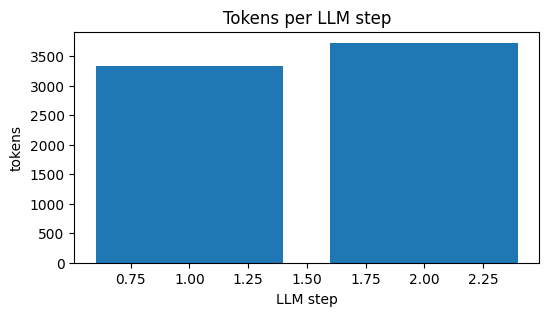

In [ ]:
import matplotlib.pyplot as plt

steps = []
tokens = []
t0 = None
times = []

for snap in run.snapshots:
    if snap.step_id == "llm_processor":
        steps.append(len(steps)+1)
        tok = snap.state_data.get("total_tokens") or 0
        tokens.append(int(tok))
        if t0 is None:
            t0 = snap.timestamp
        times.append((snap.timestamp - t0).total_seconds())

plt.figure(figsize=(6,3))
plt.bar(steps, tokens)
plt.xlabel("LLM step")
plt.ylabel("tokens")
plt.title("Tokens per LLM step")
plt.show()

In [ ]:
from lib.messages import AIMessage, ToolMessage

rows = []
for msg in (final.get("messages") or []):
    if isinstance(msg, AIMessage) and msg.tool_calls:
        for tc in msg.tool_calls:
            rows.append(("call", tc.function.name, tc.function.arguments))
    if isinstance(msg, ToolMessage):
        rows.append(("result", msg.name, (msg.content[:180]+"...") if len(msg.content)>180 else msg.content))

for kind, name, info in rows:
    print(f"{kind:6} | {name:20} | {info}")

call   | retrieve_game        | {"query":"Gran Turismo"}
result | retrieve_game        | {"status": "ok", "results": [{"Name": "Gran Turismo 5", "Platform": "PlayStation 3", "YearOfRelease": 2010, "Description": "A comprehensive racing simulator featuring a vast select...
call   | retrieve_game        | {"query":"Gran Turismo"}
result | retrieve_game        | {"status": "ok", "results": [{"Name": "Gran Turismo 5", "Platform": "PlayStation 3", "YearOfRelease": 2010, "Description": "A comprehensive racing simulator featuring a vast select...
call   | retrieve_game        | {"query":"seminal racing titles from the 1990s","n_results":5}
result | retrieve_game        | {"status": "ok", "results": [{"Name": "Gran Turismo", "Platform": "PlayStation 1", "YearOfRelease": 1997, "Description": "A realistic racing simulator featuring a wide array of car...


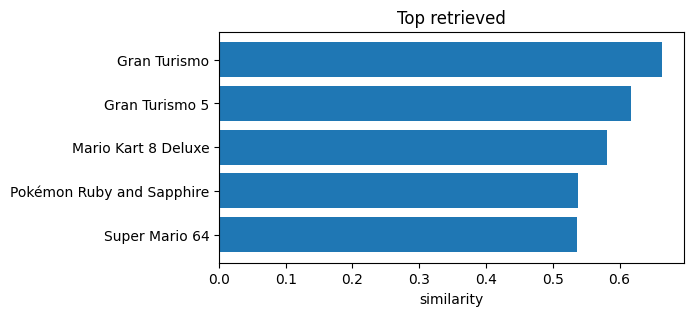

In [20]:
import matplotlib.pyplot as plt, json

last_tool = next((m for m in reversed(final["messages"]) if isinstance(m, ToolMessage)), None)
if last_tool:
    data = json.loads(last_tool.content)
    if data.get("results"):
        names = [r["Name"] for r in data["results"][:5]]
        sims = [r.get("similarity", 0) for r in data["results"][:5]]
        plt.figure(figsize=(6,3))
        plt.barh(names[::-1], sims[::-1])
        plt.xlabel("similarity")
        plt.title("Top retrieved")
        plt.show()